<a href="https://colab.research.google.com/github/wicky818/UTKFace_Deep_Learning/blob/main/UTKFace_DeepLearning_Race_Predictions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install wandb -q
!pip install tensorflow==2.7.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Getting Data

In [2]:
!git clone https://github.com/wicky818/UTKFace_Deep_Learning.git

fatal: destination path 'UTKFace_Deep_Learning' already exists and is not an empty directory.


In [3]:
!ls

drive  sample_data  UTKFace_Deep_Learning


In [4]:
import os

os.chdir("/content/UTKFace_Deep_Learning")
images = os.listdir('/content/UTKFace_Deep_Learning/dataset/UTKFace')
print('Total number of images: ', len(images))

Total number of images:  23708


In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
from PIL import Image, ImageOps
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

In [6]:
import datetime
import time
import numpy as np
import pandas as pd
from packaging import version
from collections import Counter

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, BatchNormalization, Dropout, Flatten, Input, Dense
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical

# Loading Data

[age] is an integer from 0 to 116, indicating the age\
[gender] is either 0 (male) or 1 (female)\
[race] is an integer from 0 to 4, denoting White, Black, Asian, Indian, and Others (like Hispanic, Latino, Middle Eastern).\
[date&time] is in the format of yyyymmddHHMMSSFFF, showing the date and time an image was collected to UTKFace

In [7]:
images = []
ages = []
genders = []
race = []

for i in os.listdir('/content/UTKFace_Deep_Learning/dataset/UTKFace')[0:10000]:
    split = i.split('_')
    ages.append((split[0]))
    genders.append((split[1]))
    race.append((split[2]))

    images.append(Image.open('/content/UTKFace_Deep_Learning/dataset/UTKFace/' + i))

In [8]:
images = pd.Series(list(images), name = 'Images')
ages = pd.Series(list(ages), name = 'Ages')
genders = pd.Series(list(genders), name = 'Genders')
race = pd.Series(list(race), name = 'Races')

df = pd.concat([images, ages, genders, race], axis=1)

In [9]:
df["Races"].unique()

array(['3', '0', '2', '1', '4', '20170116174525125.jpg.chip.jpg'],
      dtype=object)

In [10]:
# Cleanup bad data points without "Races"

df.drop(df[df["Races"] == "20170116174525125.jpg.chip.jpg"].index, inplace = True)
df.drop(df[df["Races"] == '20170109142408075.jpg.chip.jpg'].index, inplace = True)
df.drop(df[df["Races"] == '20170109150557335.jpg.chip.jpg'].index, inplace = True)

In [11]:
df['Ages'] = df['Ages'].astype(int)
df['Genders'] = df['Genders'].astype(int)
df['Races'] = df['Races'].astype(int)

In [12]:
df["Races"].unique()

array([3, 0, 2, 1, 4])

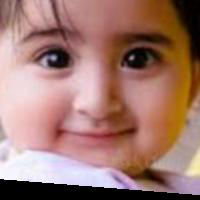

1 1 3


In [13]:
display(df['Images'][0])
print(df['Ages'][0], df['Genders'][0], df['Races'][0])

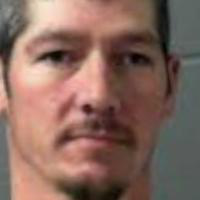

37 0 0


In [14]:
display(df['Images'][1])
print(df['Ages'][1], df['Genders'][1], df['Races'][1])

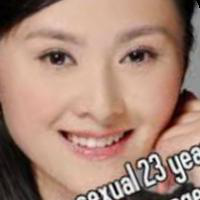

24 1 2


In [15]:
display(df['Images'][2])
print(df['Ages'][2], df['Genders'][2], df['Races'][2])

# Exploratory Data Analysis

In [16]:
df.head()

,Images,Ages,Genders,Races
0,<PIL.JpegImagePlugin.JpegImageFile image mode=...,1,1,3
1,<PIL.JpegImagePlugin.JpegImageFile image mode=...,37,0,0
2,<PIL.JpegImagePlugin.JpegImageFile image mode=...,24,1,2
3,<PIL.JpegImagePlugin.JpegImageFile image mode=...,16,1,3
4,<PIL.JpegImagePlugin.JpegImageFile image mode=...,42,0,1


In [17]:
df.Races.unique()

array([3, 0, 2, 1, 4])

In [18]:
sns.set(rc={'figure.figsize':(11.7,8.27)})

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


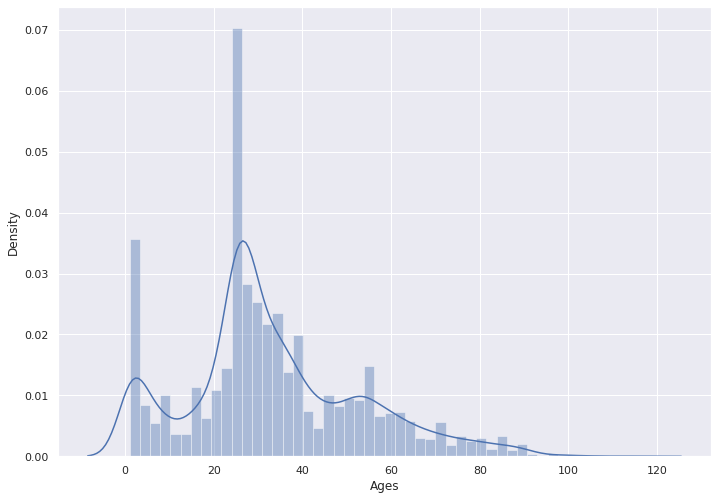

In [19]:
sns.distplot(df["Ages"])

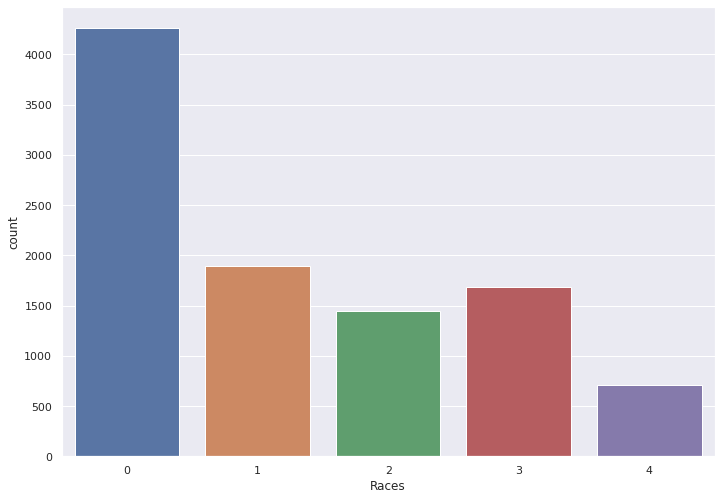

In [20]:
sns.countplot(x = "Races", data = df)

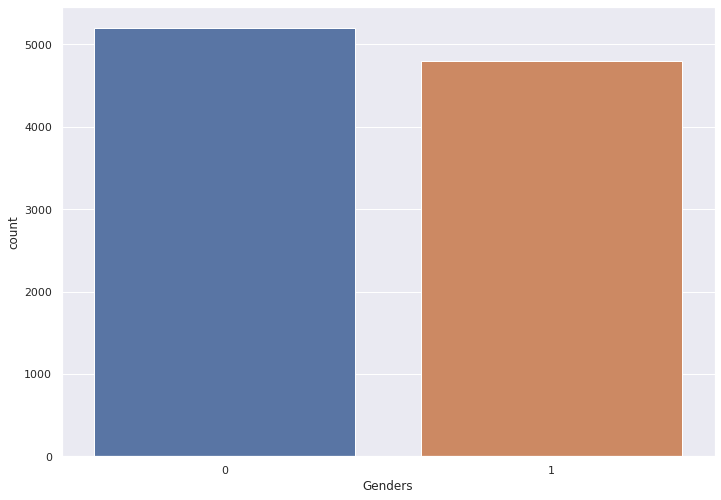

In [21]:
sns.countplot(x = "Genders", data = df)

# Age Prediction

In [22]:
df.shape

(9999, 4)

In [23]:
x = []
y = []

for i in range(len(df)):
    df['Images'].iloc[i] = df['Images'].iloc[i].resize((200,200), Image.ANTIALIAS)
    ar = np.asarray(df['Images'].iloc[i])
    x.append(ar)
    agegen = [int(df['Ages'].iloc[i]), int(df['Genders'].iloc[i]), int(df['Races'].iloc[i])]
    y.append(agegen)
x = np.array(x)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [24]:
x.shape

(9999, 200, 200, 3)

In [25]:
len(y)

9999

In [26]:
df.to_csv("data.csv", index=None)
np.save('file_name', x)

In [27]:
!git clone https://github.com/wicky818/UTKFace_Deep_Learning/dataset.git
!cd dataset.git

fatal: destination path 'dataset' already exists and is not an empty directory.
/bin/bash: line 0: cd: dataset.git: No such file or directory


In [28]:
y_age = df['Ages']
y_gender = df['Genders']
y_race = df['Races']

x_train_age, x_test_age, y_train_age, y_test_age = train_test_split(x, y_age, test_size=0.2, random_state=85)
x_train_gender, x_test_gender, y_train_gender, y_test_gender = train_test_split(x, y_gender, test_size=0.2, random_state=85)
x_train_race, x_test_race, y_train_race, y_test_race = train_test_split(x, y_race, test_size=0.2, random_state=85)

In [29]:
y_train_age.shape

(7999,)

x_train_age.shape

In [30]:
x_train_age.shape

(7999, 200, 200, 3)

In [31]:
y_train_age

4763     28
2458     55
1515     30
1805     31
1963     33
       ... 
1573     61
5716     40
6709     29
1587    100
4459     36
Name: Ages, Length: 7999, dtype: int64

In [32]:
x_train_age = x_train_age.astype(int)

# Modeling


# Race Model

In [33]:
# my_model directory
!ls /content/drive/MyDrive/UTKFace

# Contains an assets folder, saved_model.pb, and variables folder.
!ls /content/drive/MyDrive/UTKFace/saved_model/Race_model

'Final Paper write-up.gdoc'   model   Notebooks   saved_model
assets	keras_metadata.pb  saved_model.pb  variables


In [34]:
model = tf.keras.models.load_model('/content/drive/MyDrive/UTKFace/saved_model/Race_model')

# Check its architecture
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 196, 196, 32)      2432      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 98, 98, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 96, 96, 48)        13872     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 48, 48, 48)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 46, 46, 48)        20784     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 23, 23, 48)       0

In [35]:
datagen = ImageDataGenerator(
      rescale=1./255., width_shift_range = 0.1, height_shift_range = 0.1, horizontal_flip = True)

x_train_mod_race,x_val_race, y_train_mod_race, y_val_race = train_test_split(x_train_race, y_train_race, test_size=0.2, random_state=85)

test_datagen = ImageDataGenerator(rescale=1./255)

train2 = datagen.flow(x_train_mod_race, y_train_mod_race, batch_size=32)

test2 = test_datagen.flow(
        x_val_race, y_val_race,
        batch_size=32)

checkpoint = ModelCheckpoint(filepath='/content/drive/MyDrive/UTKFace/saved_model/Race_model', 
                             monitor='val_accuracy',
                             verbose=1, 
                             save_best_only=True,
                             mode='max')

history1 = model.fit(train2, epochs=50, shuffle=True, validation_data = test2, 
                        callbacks=[checkpoint, tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)])

Epoch 1/50
200/200 [==============================] - ETA: 0s - loss: 1.0839 - accuracy: 0.5763
Epoch 00001: val_accuracy improved from -inf to 0.60750, saving model to /content/drive/MyDrive/UTKFace/saved_model/Race_model
INFO:tensorflow:Assets written to: /content/drive/MyDrive/UTKFace/saved_model/Race_model/assets
200/200 [==============================] - 53s 256ms/step - loss: 1.0839 - accuracy: 0.5763 - val_loss: 1.0307 - val_accuracy: 0.6075
Epoch 2/50
200/200 [==============================] - ETA: 0s - loss: 1.0864 - accuracy: 0.5707
Epoch 00002: val_accuracy improved from 0.60750 to 0.83625, saving model to /content/drive/MyDrive/UTKFace/saved_model/Race_model
INFO:tensorflow:Assets written to: /content/drive/MyDrive/UTKFace/saved_model/Race_model/assets
200/200 [==============================] - 51s 255ms/step - loss: 1.0864 - accuracy: 0.5707 - val_loss: 1.7325 - val_accuracy: 0.8363
Epoch 3/50
200/200 [==============================] - ETA: 0s - loss: 1.0788 - accuracy: 0.

In [36]:
loss, accuracy = model.evaluate(x_test_race, y_test_race)
print('test set accuracy: ', accuracy * 100, "%")

63/63 [==============================] - 1s 9ms/step - loss: 613.5171 - accuracy: 0.9840
test set accuracy:  98.4000027179718 %


In [37]:
train_losses = history1.history["loss"]
train_accs = history1.history["accuracy"]
val_losses = history1.history["val_loss"]
val_accs = history1.history["val_accuracy"]
epochs = len(train_losses)

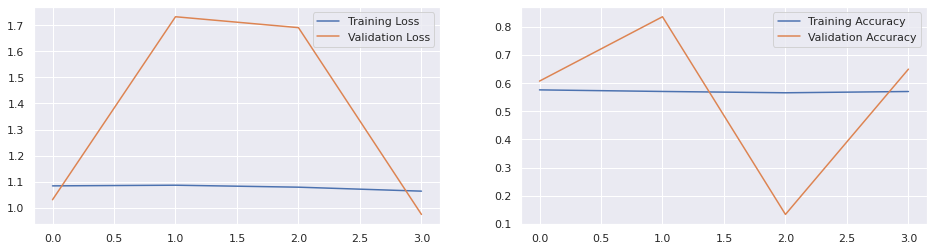

In [38]:
plt.figure(figsize=(16, 4))
for i, metrics in enumerate(zip([train_losses, train_accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
plt.show()